In [57]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os
from plot_utils import adjust_plot
import matplotlib.pyplot as plt

import mplhep as hep
hep.style.use("CMS")

awkward version  1.10.3
coffea version  0.7.21


In [2]:
class QCDProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        frac_axis = hist.axis.Regular(150, 0, 2.0, name="frac", label=r"Fraction")
        ptgen_axis = hist.axis.Variable([200,260,350,460,550,650,760,13000], name="ptgen", label=r"p_{T,RECO} (GeV)")
        n_axis = hist.axis.Regular(5, 0, 5, name="n", label=r"Number")
        pt_axis = hist.axis.Variable([10,20,30,40,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000], name="pt", label=r"$p_{T}$ [GeV]") #erased 4000 and 5000

        pileup_axis = hist.axis.Variable([0,10,20,30,40,50,60,90],name = "pileup", label = r"$\mu$" )
        #eta_axis = hist.axis.Regular(15, -4,4, name = "eta", label = r"$eta$")
        # eta_axis = hist.axis.Variable([0, 0.261, 0.522, 0.783,  1.044, 1.305, 1.566, 1.74, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853,
        #                               2.964, 3.139, 5],name = "eta", label = r"$\eta$")
        #eta_axis = hist.axis.Variable([-5.191, -3.839, -3.489, -3.139, -2.964, -2.853, -2.65, -2.5, -2.322,-2.172,-2.043, -1.93, -1.74, -1.566,-1.305,-1.044 ,-0.783 ,-0.522, -0.261, 0, 0.261, 0.522, 0.783, 1.044, 1.305, 1.566, 1.74, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853,], name = "eta", label = r"$\eta$")
        
        #eta_axis = hist.axis.Variable([0, 1.305,  2.5, 2.65, 2.853,
                                        #5.191],name = "eta", label = r"$\eta$")
        
        eta_axis = hist.axis.Variable([ 0, 0.5, 0.8, 1.1, 1.3, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3, 3.2, 4.7],name = "eta", label = r"$\eta$")
        
        
        rho_axis = hist.axis.Variable( [0, 7.47, 13.49, 19.52, 25.54, 31.57, 37.59, 90], 
                                      name = 'rho', label = r'$\rho$')
        
        jer_axis = hist.axis.Regular(100, 0.995, 1.030, name = 'jer', label = "JER" )
        
        
        h_njet_gen = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        h_njet_reco = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        
        h_pt_reco_over_gen = hist.Hist( dataset_axis, pt_axis, frac_axis, eta_axis, rho_axis, storage = "weight", label = "Counts")
        #h_pt_reco_over_raw = hist.Hist( dataset_axis, pt_raw_axis,n_axis, frac_axis, eta_axis, pileup_axis, storage = "weight", label = "Counts")
        
        response_pt = {}
        for i in range(len(pt_axis.centers)):
            response_pt[str(i)] = np.array([])
        
        
        #self.df = pd.read_csv( "Summer19UL17_JRV2_MC_PtResolution_AK4PFchs.txt", delimiter='\s+', skiprows = 1, names = ['eta_low','eta_high', 'rho_low', 'rho_high', 'unknown','pt_low','pt_high','par0','par1','par2','par3'])
    
        self.n_pt_bins = len(pt_axis.centers)
        self.pt_edges = pt_axis.edges
        
        cutflow = {}
        
        self.hists = {
            "njet_gen":h_njet_gen,
            "njet_reco":h_njet_reco,
            "pt_reco_over_gen": h_pt_reco_over_gen,
            "response_pt": response_pt,
            "cutflow":cutflow
        }
        
    @property
    def accumulator(self):
        return self.hists, self.n_pt_bins, self.pt_edges
    
    def process(self, events):
        dataset = events.metadata['dataset']
        
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)
            


        gen_vtx = events.GenVtx.z
        reco_vtx = events.PV.z
        
        
        # delta_z < 0.2 between reco and gen
        events = events[np.abs(gen_vtx - reco_vtx) < 0.2]
        
        
        # loose jet ID
        events.Jet = events.Jet[events.Jet.jetId > 0]
        

        events = events[ak.num(events.Jet) > 0 ]
        dataset = events.metadata['dataset']
        
        genjets = events.GenJet[:,0:3]
        recojets = genjets.nearest(events.Jet, threshold = 0.2)
        
        sel = ~ak.is_none(recojets, axis = 1)
        
        genjets = genjets[sel]
        recojets = recojets[sel]
             
        ptresponse = recojets.pt/genjets.pt
        
        n_reco_vtx = events.PV.npvs #the number of primary vertices
        n_pileup = events.Pileup.nPU #number of pileupss
        rho = events.fixedGridRhoFastjetAll

        sel = ~ak.is_none(ptresponse,axis=1)
        ptresponse = ptresponse[sel]
        recojets = recojets[sel]
        genjets = genjets[sel]
        
        sel2 = ak.num(ptresponse) > 2
        
        recojets = recojets[sel2]
        genjets = genjets[sel2]
        
        ptresponse = ptresponse[sel2]
        ptresponse_raw = (recojets.pt * (1 - recojets.rawFactor))/genjets.pt
        
        n_reco_vtx = n_reco_vtx[sel2]
        n_pileup = n_pileup[sel2]
        rho = rho[sel2]
        
        n_reco_vtx = ak.broadcast_arrays(n_reco_vtx, recojets.pt)[0]
        n_pileup = ak.broadcast_arrays(n_pileup, recojets.pt)[0]
        rho = ak.broadcast_arrays(rho, recojets.pt)[0]
        
        
        ### finding median response here ##
        # for i in range(self.n_pt_bins):
        #     self.hists["response_pt"][str(i)] = np.append((self.hists["response_pt"][str(i)],ak.flatten(ptresponse)[np.digitize(ak.flatten(genjets.pt), self.pt_edges) == i ].to_numpy()),axis = None)
        # for i in range(self.n_pt_bins):
        #     with open(str(i)+".txt","a") as f:
        #         for item in ak.flatten(ptresponse)[np.digitize(ak.flatten(genjets.pt), self.pt_edges) == i ].to_numpy():
        #             f.write("%s\n" % item)
                
        
        self.hists["pt_reco_over_gen"].fill( dataset = dataset, pt = ak.flatten(genjets.pt),frac = ak.flatten(ptresponse), 
                                            rho = ak.flatten(rho), eta = np.abs(ak.flatten(genjets.eta)))
        
        #self.hists["pt_reco_over_raw"].fill( dataset = dataset, pt_raw = ak.flatten(recojets.pt*(1 - recojets.rawFactor)), n = ak.flatten(n_reco_vtx) ,frac = ak.flatten(ptresponse_raw), eta = np.abs(ak.flatten(genjets.eta)), pileup = ak.flatten(n_pileup))
        
            
        return self.hists
    
    def postprocess(self, accumulator):
        return accumulator
        

In [3]:
import pandas as pd
def computeJER(pt, eta, rho, df):
    df = df[ (eta > df['eta_low']) &  (eta <= df['eta_high']) & (rho > df['rho_low']) & (rho <= df['rho_high'])  ]
    p0 = df['par0']
    p1 = df['par1']
    p2 = df['par2']
    p3 = df['par3']
    x = pt
    return np.sqrt(p0*np.abs(p0)/(x*x)+p1*p1*np.power(x,p3) + p2*p2)
df = pd.read_csv( "Summer19UL17_JRV2_MC_PtResolution_AK4PFchs.txt", delimiter='\s+', skiprows = 1, names = ['eta_low','eta_high', 'rho_low', 'rho_high', 'unknown','pt_low','pt_high','par0','par1','par2','par3'])
computeJER(200, -1.2, 14,df )

65    0.096868
dtype: float64

In [4]:
fileset = {}
filedir = "samples/"
prependstr = "/mnt/data/cms"


eras_mc = [
        'UL16NanoAODv9', 
        'UL16NanoAODAPVv9',
        'UL17NanoAODv9', 
        'UL18NanoAODv9'
    ]



qcd_mc_filestr = "QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_"

for era in eras_mc:
    fileset[era] = {}
    filename = filedir + qcd_mc_filestr + era + ".txt"
    with open(filename) as f:
        dy_mc_files = [prependstr + i.rstrip() for i in f.readlines() if i[0] != "#" ]
        fileset[era] = dy_mc_files

In [5]:
#skimmed_fileset

fileset = {'UL16NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/skimmed/skimmed_total.root'], 
        'UL16NanoAODAPVv9':['/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/skimmed/skimmed_total.root'],
        'UL17NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v2/skimmed/skimmed_total.root'], 
        'UL18NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/skimmed/skimmed_total.root']}

In [6]:
# #test 


fileset = {'UL18NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/skimmed/skimmed_total.root']}

In [7]:
#f = uproot.open("/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/894A5559-C6A2-7347-9C7C-2FB1EDDCCEA1.root")


In [8]:
#f["Events"]['Jet_rawFactor'].arrays(library = 'np' ) # divide the recojet pt by (1+rawFactor)

In [9]:
run = processor.Runner(
            executor = processor.FuturesExecutor(compression = None, workers = 8),
            schema=NanoAODSchema,
            chunksize=1000000,
            maxchunks=None,
            skipbadfiles=False
        )

In [11]:
output = run(
    fileset,
    "Events",
    processor_instance=QCDProcessor(),
)

fname_out = 'QCDresponse.pkl'

with open(fname_out, "wb") as f:
        pickle.dump( output, f )

Output()

In [12]:
#!cp "QCDresponse.pkl" "QCDresponse_old.pkl"

In [13]:
with open("QCDresponse.pkl", "rb") as f:
    output = pickle.load( f )

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f5091715100>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

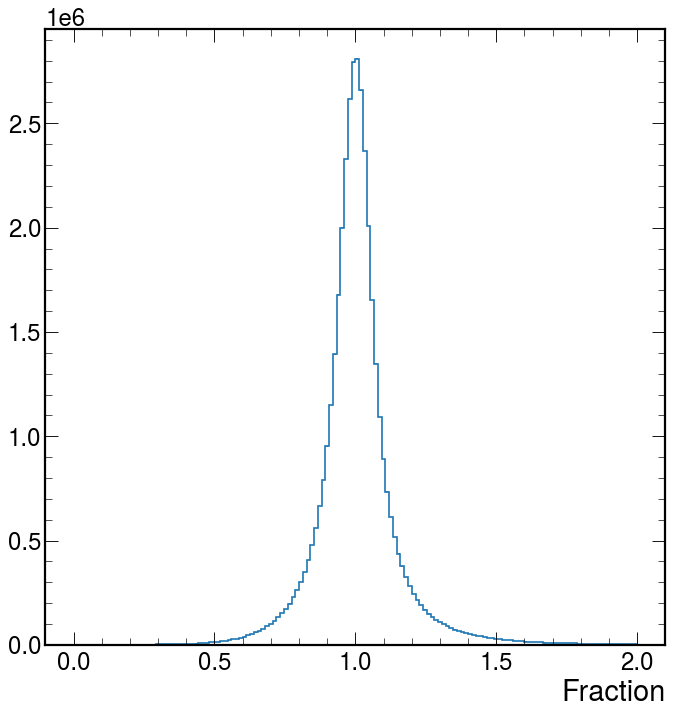

In [14]:
output["pt_reco_over_gen"].project('frac').plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f5080b9e7c0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

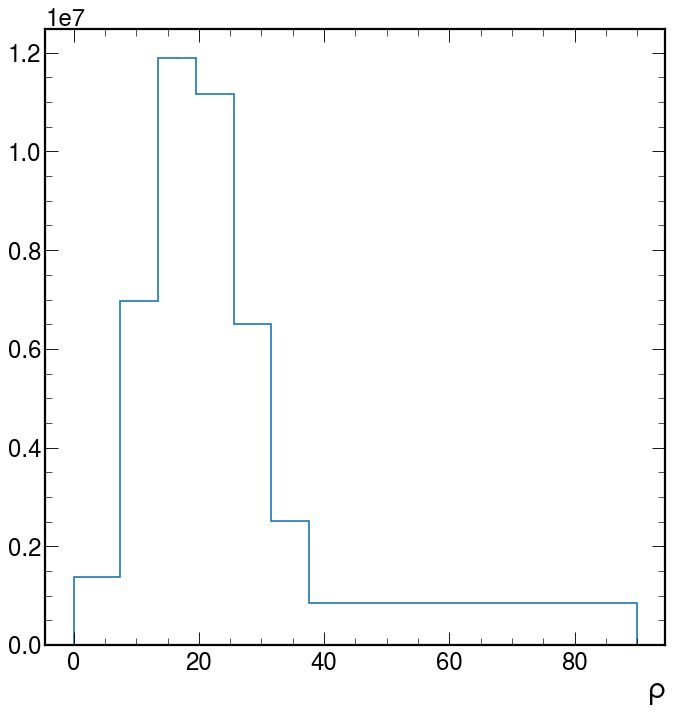

In [15]:
output["pt_reco_over_gen"].project('rho').plot()

### Bin Edges

In [16]:
hist = output["pt_reco_over_gen"]
hist.axes

(StrCategory(['UL18NanoAODv9'], growth=True, name='dataset', label='Primary dataset'),
 Variable(array([  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
         100.,  120.,  140.,  160.,  180.,  200.,  250.,  300.,  350.,
         400.,  450.,  500.,  600.,  700.,  800.,  900., 1000., 1500.,
        2000., 3000.]), name='pt', label='$p_{T}$ [GeV]'),
 Regular(150, 0, 2, name='frac', label='Fraction'),
 Variable([0, 0.5, 0.8, 1.1, 1.3, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3, 3.2, 4.7], name='eta', label='$\\eta$'),
 Variable([0, 7.47, 13.49, 19.52, 25.54, 31.57, 37.59, 90], name='rho', label='$\\rho$'))

In [26]:
hist = output["pt_reco_over_gen"]
dataset_bins = hist.axes[0].edges
pt_bins = hist.axes[1].edges
frac_bins = hist.axes[2].edges
eta_bins = hist.axes[3].edges
rho_bins = hist.axes[4].edges

### Bin centers

In [27]:

pt_values = hist.axes[1].centers
frac_values = hist.axes[2].centers
eta_values = hist.axes[3].centers
rho_values = hist.axes[4].centers

### Bin Widths

In [28]:
pt_widths = hist.axes[1].widths
frac_widths = hist.axes[2].widths
eta_widths = hist.axes[3].widths
rho_widths = hist.axes[4].widths

In [20]:
pt_values

array([  15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,   95.,
        110.,  130.,  150.,  170.,  190.,  225.,  275.,  325.,  375.,
        425.,  475.,  550.,  650.,  750.,  850.,  950., 1250., 1750.,
       2500.])

In [21]:
eta_values

array([0.25, 0.65, 0.95, 1.2 , 1.5 , 1.8 , 2.  , 2.2 , 2.4 , 2.65, 2.9 ,
       3.1 , 3.95])

In [22]:
rho_bins

array([ 0.  ,  7.47, 13.49, 19.52, 25.54, 31.57, 37.59, 90.  ])

In [23]:
hist_np = hist.to_numpy()[0]

hist_np.shape

(1, 28, 150, 13, 7)

In [24]:
hist_frac = hist.project("dataset","frac").to_numpy()[0]

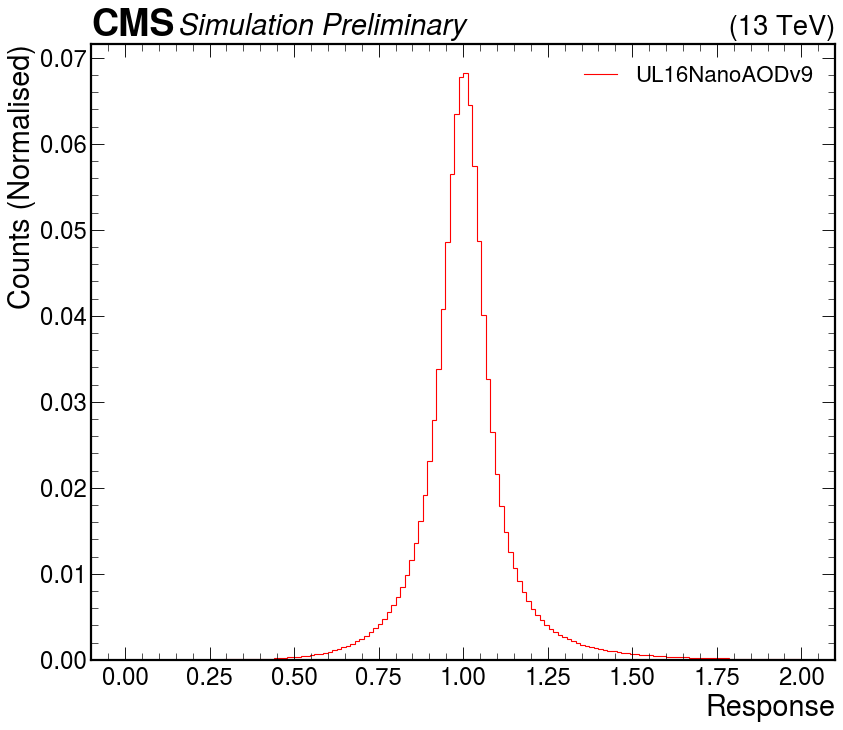

In [25]:
fig = plt.figure(figsize = (12,10))
colors = ['red', 'blue', 'orange' , 'green']
for i in range(1):
    plt.stairs( hist_frac[i]/np.sum(hist_frac[i]),frac_bins,  label = eras_mc[i], color = colors[i])
    plt.xlabel("Response")
    plt.legend(loc = 'upper right', fontsize = 20)
    plt.ylabel("Counts (Normalised)")
    hep.cms.label("Preliminary")

IndexError: index 1 is out of bounds for axis 0 with size 1

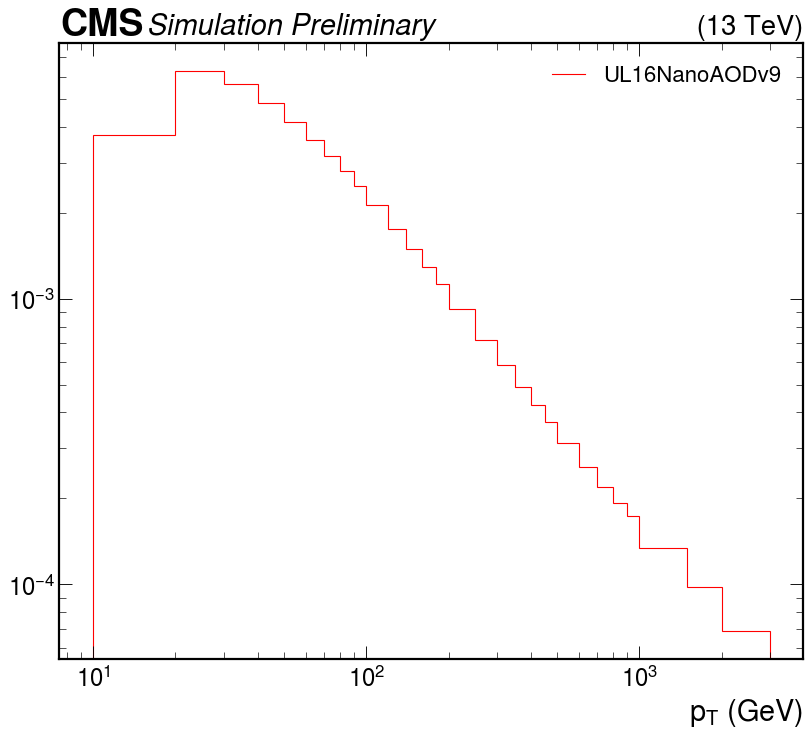

In [31]:
hist_pt = hist.project("dataset","pt").to_numpy()[0]
colors = ['red', 'blue', 'orange' , 'green']
fig = plt.figure(figsize = (12,10))
for i in range(4):
    plt.stairs( hist_pt[i]/(np.sum(hist_pt[i])* hist.axes[1].widths),pt_bins,  label = eras_mc[i], color = colors[i])
    plt.xlabel(r"$p_T$ (GeV)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc = 'upper right', fontsize = 20)
    hep.cms.label("Preliminary")

In [29]:
hist_pt = np.sum(hist_np, axis = (2,3,4,5))
colors = ['red', 'blue', 'orange' , 'green']
fig = plt.figure(figsize = (12,10))

hist_eta = np.sum(hist_np, axis = (1,2,3,5))
for i in range(4):
    plt.stairs( hist_eta[i]/np.sum(hist_eta[i]),eta_bins,  label = eras_mc[i], color = colors[i])
    plt.xlabel(r"$\eta$")
    plt.legend(loc = 'upper right', fontsize = 20)
    hep.cms.label("Preliminary")

AxisError: axis 5 is out of bounds for array of dimension 5

In [36]:
#hist_frac_pt = np.sum(hist_np, axis = (0,2,4,5) )
hist_frac_pt = hist.project("pt","frac").to_numpy()[0]

NameError: name 'hist_frac_pt' is not defined

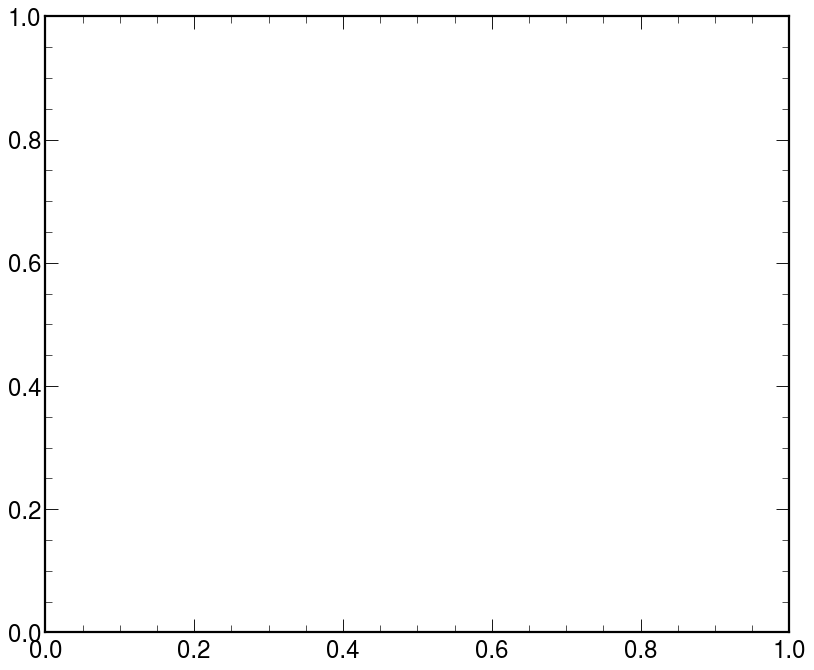

In [30]:
cm = plt.get_cmap('brg')
colors = [cm(1.*i/30) for i in range(28)]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(28):
    ax.stairs( hist_frac_pt[i]/np.sum(hist_frac_pt[i]),frac_bins,  label = str(int(pt_bins[i]))+r" <$p_T$< "  + str(int(pt_bins[i+1])) )
    ax.set_xlabel("Response")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    hep.cms.label("Preliminary")

In [40]:
from scipy.optimize import curve_fit

class Histfit:
    def __init__(self, hist_frac_pt, frac_values, pt_values):
        self.frac_values = frac_values
        self.hist_frac_pt = hist_frac_pt
        self.pt_values = pt_values
        
        self.parameters = {"mean":np.full(len(self.pt_values), None), "sigma": np.full(len(self.pt_values), None), "const":np.full(len(self.pt_values), None),"sigmaErr":np.full(len(self.pt_values), None)
                          ,"meanErr":np.full(len(self.pt_values), None)}
        
    def gauss(self,x,  x0, sigma,a):
        return (a*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
    
    def fitGauss(self, hist_frac, frac_values):
        parameters, covariance = curve_fit(self.gauss, frac_values, hist_frac) #,bounds = ([0.5,0.05,-5],[2,0.3,20])
        mean = parameters[0]
        sigma = parameters[1]
        const = parameters[2]
        meanErr = covariance[0][0]
        sigmaErr = covariance[1][1]
        return mean,sigma,const, sigmaErr, meanErr
    
    def initiate_parameters(self):
        for i in range(len(self.hist_frac_pt)):
            hist_frac = self.hist_frac_pt[i]
            results = self.fitGauss(hist_frac, self.frac_values)
            for j,key in enumerate(self.parameters.keys()):
                self.parameters[key][i] = results[j]
                
    def store_parameters(self):
        self.initiate_parameters()
        for repeater in range(2):
            for i,hist_frac in enumerate(self.hist_frac_pt):
                sel = (self.frac_values > (self.parameters["mean"][i] - 1.5*self.parameters["sigma"][i])) &  (self.frac_values < (self.parameters["mean"][i] + 1.5*self.parameters["sigma"][i]))
                frac_values = self.frac_values[sel]
                hist_frac = hist_frac[sel]

                results = self.fitGauss(hist_frac, frac_values)
                for j,key in enumerate(self.parameters.keys()):
                    self.parameters[key][i] = results[j]
    def show_fit(self, i):
        hist_frac = self.hist_frac_pt[i]
        sel = (self.frac_values > (self.parameters["mean"][i] - 1.5*self.parameters["sigma"][i])) &  (self.frac_values < (self.parameters["mean"][i] + 1.5*self.parameters["sigma"][i]))
        frac_values = self.frac_values[sel]
        hist_frac = hist_frac[sel]
        results = self.fitGauss(hist_frac, frac_values)
        
        print("Mean: {} ".format(results[0]))
        print("Width: {}".format(results[1]))
        for j,key in enumerate(self.parameters.keys()):
                    self.parameters[key][i] = results[j]
                
        plt.plot(self.frac_values, self.hist_frac_pt[i], 'b-', label = "Response")
        plt.plot(frac_values, self.gauss(frac_values, results[0], results[1], results[2]), 'black',linestyle = '--' ,label = "Gauss Fit")
            
        

In [41]:
histfit = Histfit(hist_frac_pt, frac_values, pt_values)

In [42]:
histfit.store_parameters()

Mean: 1.0025822838980123 
Width: 0.12754561738486392


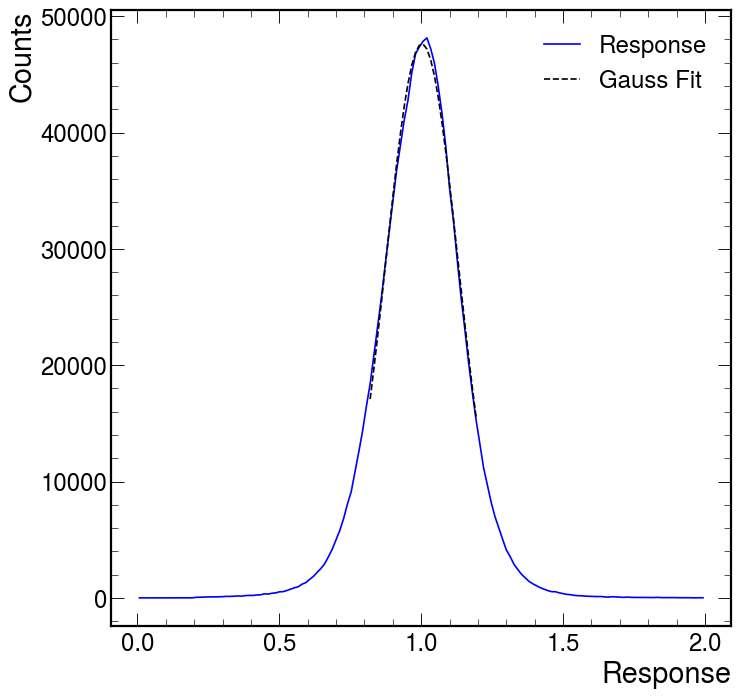

In [43]:
histfit.show_fit(6)
plt.xlabel("Response")
plt.ylabel("Counts")
plt.legend()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

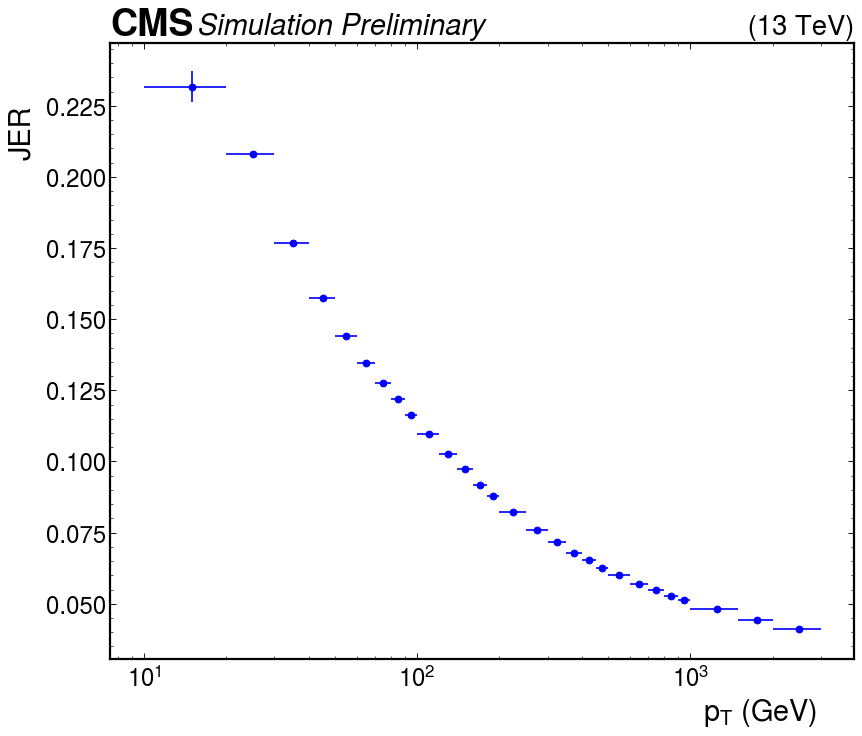

In [44]:
sigma_list = histfit.parameters["sigma"]
sigma_error_list  = histfit.parameters["sigmaErr"]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JER", xscale = 'log')
hep.cms.label("Preliminary")
#plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

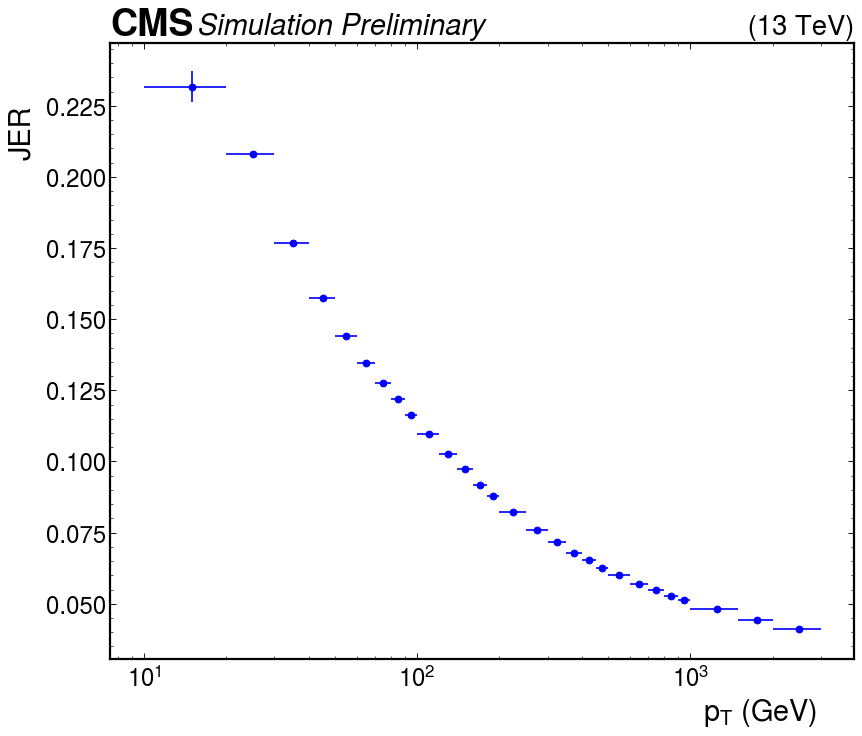

In [45]:
sigma_list = histfit.parameters["sigma"]
sigma_error_list  = histfit.parameters["sigmaErr"]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JER", xscale = 'log')
hep.cms.label("Preliminary")
#plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

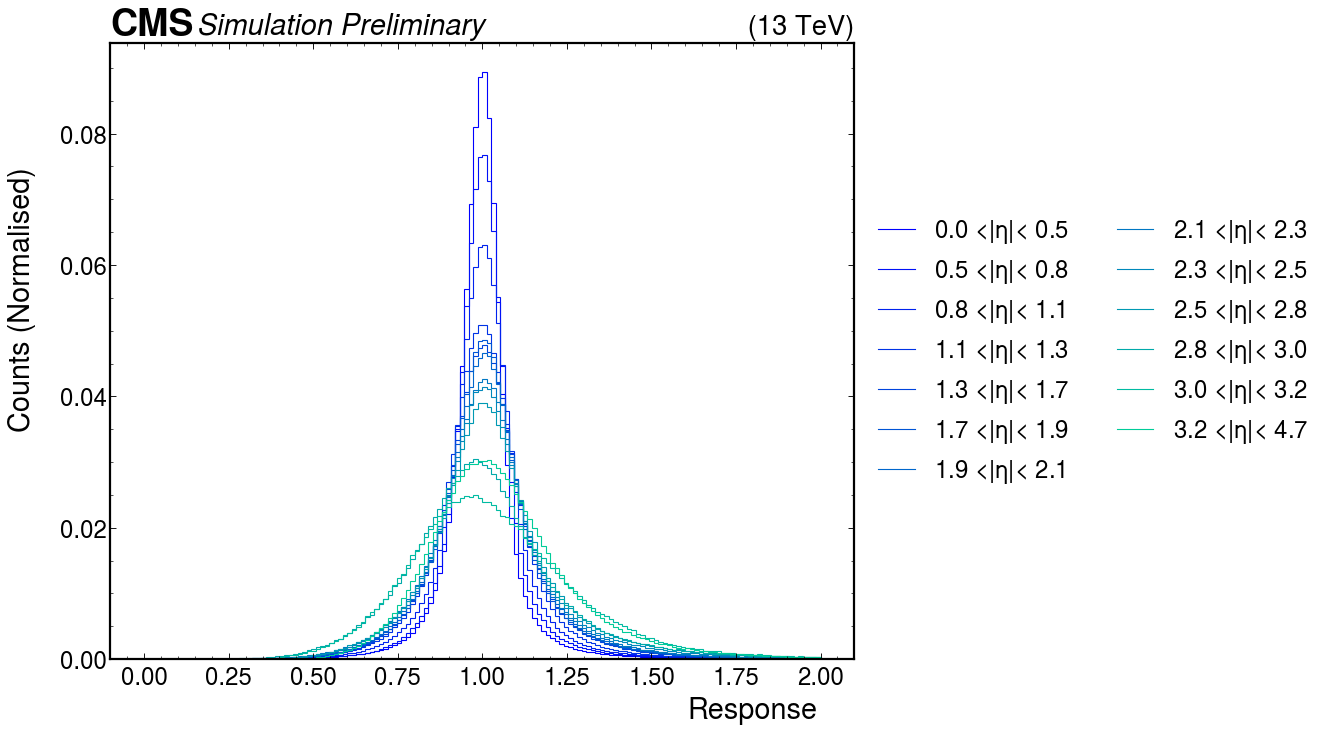

In [46]:
#hist_frac_eta = np.sum(hist_np, axis = (0,1,2,5) )
#hist_frac_eta = hist_frac_eta.T
fig = plt.figure(figsize = (12,10))

hist_frac_eta = hist.project('eta','frac').to_numpy()[0]
cm = plt.get_cmap('winter')
colors = [cm(1.*i/15) for i in range(len(eta_values))]
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(len(eta_values)):
    ax.stairs( hist_frac_eta[i]/np.sum(hist_frac_eta[i]),frac_bins,  label = str(round(eta_bins[i],2))+r" <$|\eta|$< "  + str(round(eta_bins[i+1],2)) )
    ax.set_xlabel("Response")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
hep.cms.label("Preliminary")

In [47]:
histfit_eta = Histfit(hist_frac_eta, frac_values, eta_values)
histfit_eta.store_parameters()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

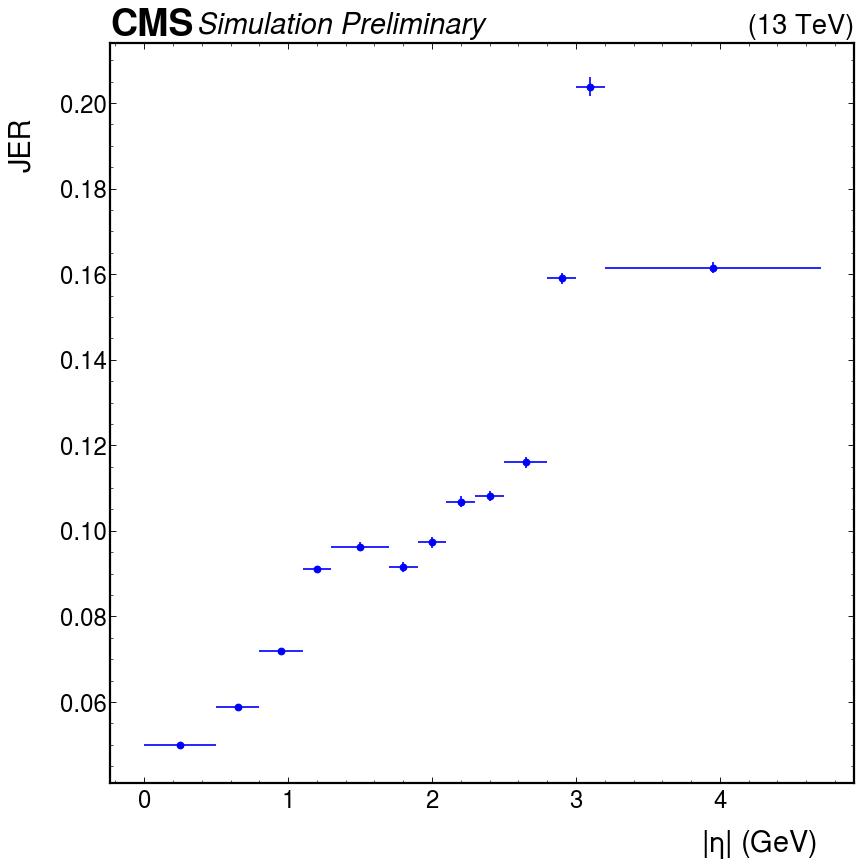

In [48]:
fig = plt.figure(figsize = (12,12))
sigma_list = histfit_eta.parameters["sigma"]
sigma_error_list  = histfit_eta.parameters["sigmaErr"]

ax = plt.subplot()
ax.errorbar(eta_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = eta_widths/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$|\eta|$ (GeV)", ylabel = "JER")
#plt.xscale("log")
hep.cms.label("Preliminary")

Mean: 1.0026741671452961 
Width: 0.09630646626329388


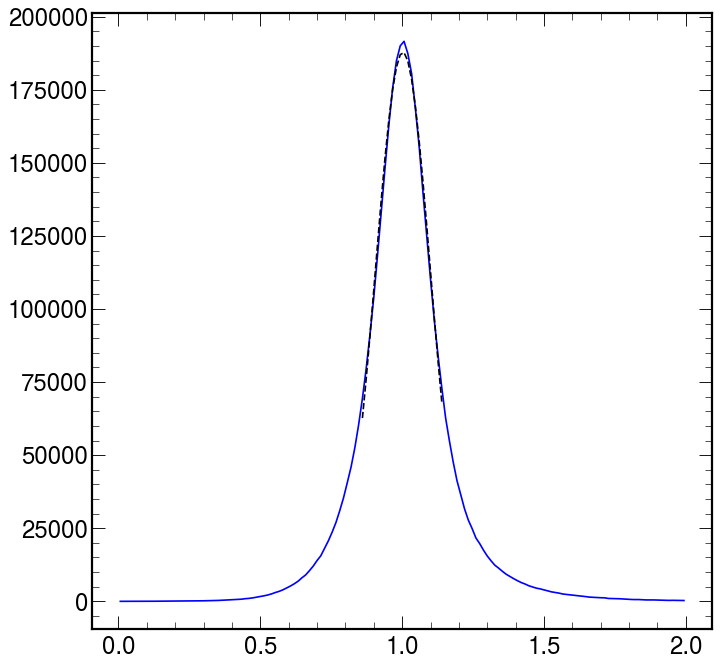

In [49]:
histfit_eta.show_fit(4)

In [327]:
fig = plt.figure(figsize = (12,10))
hist_frac_pileup = hist.project("pileup","frac").to_numpy()[0]
cm = plt.get_cmap('brg')
colors = [cm(1.*i/9) for i in range(9)]
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(7):
    ax.stairs( hist_frac_pileup[i]/np.sum(hist_frac_pileup[i]),frac_bins,  label = str(int(pileup_bins[i]))+r" <$\mu$< "  + str(int(pileup_bins[i+1])) )
    ax.set_xlabel("Response")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
ax.legend() 
hep.cms.label("Preliminary")

ValueError: The axis name pileup could not be found

<Figure size 480x400 with 0 Axes>

In [328]:
# for i in range(len(hist_frac_pileup)):
#     hist_frac_pileup[i] = hist_frac_pileup[i]/np.sum(hist_frac_pileup[i])
    
histfit_frac_pileup = Histfit(hist_frac_pileup, frac_values, pileup_values)
histfit_frac_pileup.store_parameters()

NameError: name 'hist_frac_pileup' is not defined

In [329]:
hist_frac_pileup.shape

NameError: name 'hist_frac_pileup' is not defined

In [330]:
sigma_list = histfit_frac_pileup.parameters["sigma"]
sigma_error_list  = histfit_frac_pileup.parameters["sigmaErr"]

ax = plt.subplot()
ax.errorbar(pileup_values[:], sigma_list[:], np.power(sigma_error_list[:], 0.5), xerr = pileup_widths[:]/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$\mu$ ", ylabel = "JER")
#plt.xscale("log")


NameError: name 'histfit_frac_pileup' is not defined

In [331]:

histfit_frac_pileup.show_fit(3)

NameError: name 'histfit_frac_pileup' is not defined

In [332]:
hist_pileup_pt_frac = hist.project("pileup","pt","frac").to_numpy()[0]

ValueError: The axis name pileup could not be found

NameError: name 'hist_pileup_pt_frac' is not defined

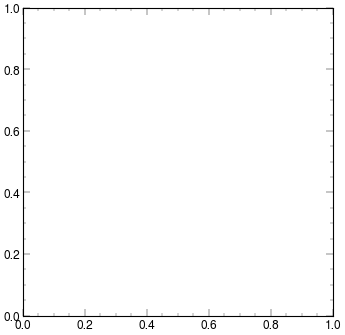

In [333]:
import itertools
ax = plt.subplot()
markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
for i_pileup, hist_pt_frac in enumerate(hist_pileup_pt_frac):
    histfit = Histfit(hist_pt_frac, frac_values, pt_values)
    histfit.store_parameters()
    
    sigma_list = histfit.parameters["sigma"]
    sigma_error_list  = histfit.parameters["sigmaErr"]

    ax.errorbar(pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(pileup_bins[i_pileup],2))+r" <$\mu$< "  + str(round(pileup_bins[i_pileup+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
    plt.xlabel(r"$p_T$ (GeV)")
    plt.xscale("log")
    hep.cms.label("Preliminary")
    plt.legend()
    #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')

In [54]:
hist_eta_pileup_pt_frac = hist.project("eta","pileup","pt","frac").to_numpy()[0]

In [55]:

# markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
# for i_eta,hist_pileup_pt_frac in enumerate(hist_eta_pileup_pt_frac):
#     ax = plt.subplot()
#     for i_pileup, hist_pt_frac in enumerate(hist_pileup_pt_frac):
#         histfit = Histfit(hist_pt_frac, frac_values, pt_values)
#         histfit.store_parameters()

#         sigma_list = histfit.parameters["sigma"]
#         sigma_error_list  = histfit.parameters["sigmaErr"]

        
#         ax.errorbar(pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(pileup_bins[i_pileup],2))+r" <$\mu$< "  + str(round(pileup_bins[i_pileup+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
        
#         plt.xlabel(r"$p_T$ (GeV)")
#         plt.ylabel("JER")
#         plt.xscale("log")
#         hep.cms.label("Preliminary")
#         plt.legend()
#         #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')
#     ax.text(s = str(round(eta_bins[i_eta],3))+ r" <$\eta$< " + str(round(eta_bins[i_eta + 1],3)), x = 0.35, y = 0.93, fontsize = 21, transform=ax.transAxes)
#     plt.show()

In [56]:

# histfit = Histfit(hist_eta_pileup_pt_frac[10][5], frac_values, pt_values)
# histfit.store_parameters()

In [57]:
# sigma_list = histfit.parameters["sigma"]
# sigma_error_list  = histfit.parameters["sigmaErr"]
# fig = plt.figure(figsize = (12,10))
# ax = plt.subplot()
# ax.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
# #plt.xlabel(r"$p_T$ (GeV)")
# adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JER", xscale = 'log')
# hep.cms.label("Preliminary")
# #plt.xscale("log")

In [58]:
eta_values

array([0.6525, 1.9025, 2.575 , 2.7515, 4.022 ])

In [59]:
median_list = np.array([])
for i in range(1,27):
    median = np.median(np.loadtxt(str(i)+".txt"))
    print(median)
    median_list = np.concatenate((median_list, median), axis = None)

FileNotFoundError: 1.txt not found.

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

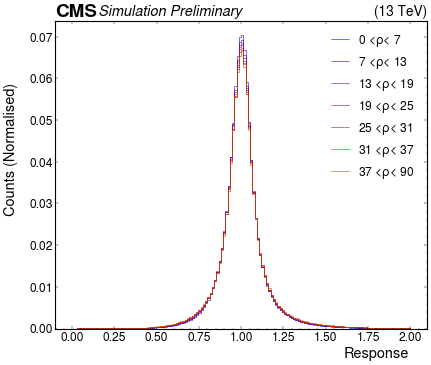

In [334]:
fig = plt.figure(figsize = (12,10))
hist_frac_rho = hist.project("rho","frac").to_numpy()[0]
cm = plt.get_cmap('brg')
colors = [cm(1.*i/9) for i in range(len(rho_values))]
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(7):
    ax.stairs( hist_frac_rho[i]/np.sum(hist_frac_rho[i]),frac_bins,  label = str(int(rho_bins[i]))+r" <$\rho$< "  + str(int(rho_bins[i+1])) )
    ax.set_xlabel("Response")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
ax.legend() 
hep.cms.label("Preliminary")

In [335]:
histfit_frac_rho = Histfit(hist_frac_rho, frac_values, rho_values)
histfit_frac_rho.store_parameters()

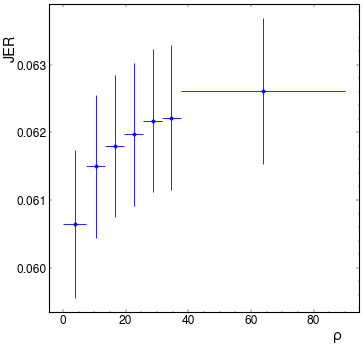

In [336]:
sigma_list = histfit_frac_rho.parameters["sigma"]
sigma_error_list  = histfit_frac_rho.parameters["sigmaErr"]

ax = plt.subplot()
ax.errorbar(rho_values[:], sigma_list[:], np.power(sigma_error_list[:], 0.5), xerr = rho_widths[:]/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$\rho$ ", ylabel = "JER")
#plt.xscale("log")

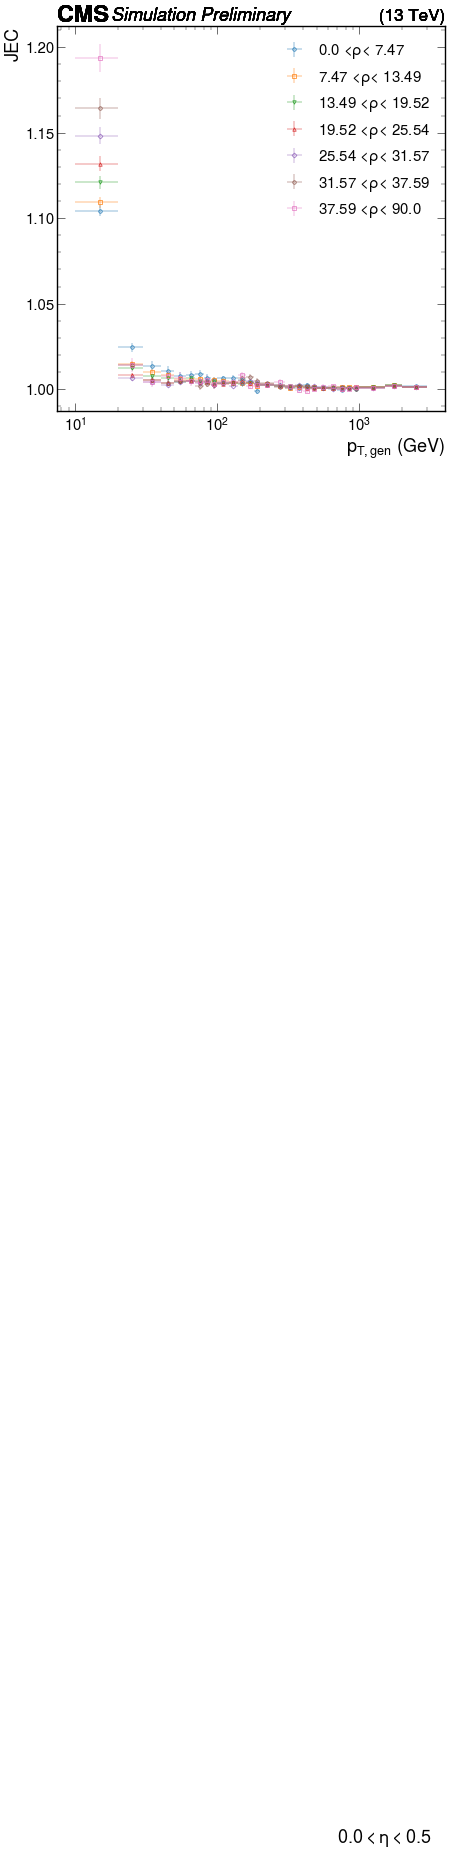

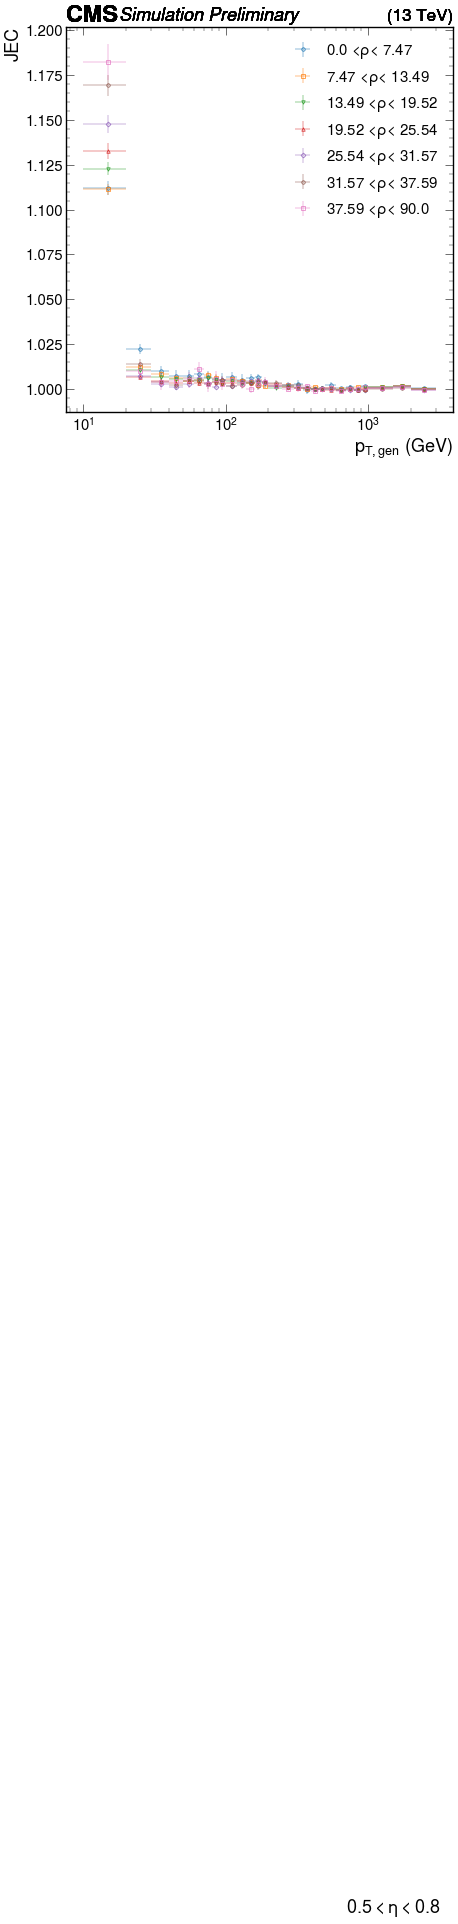

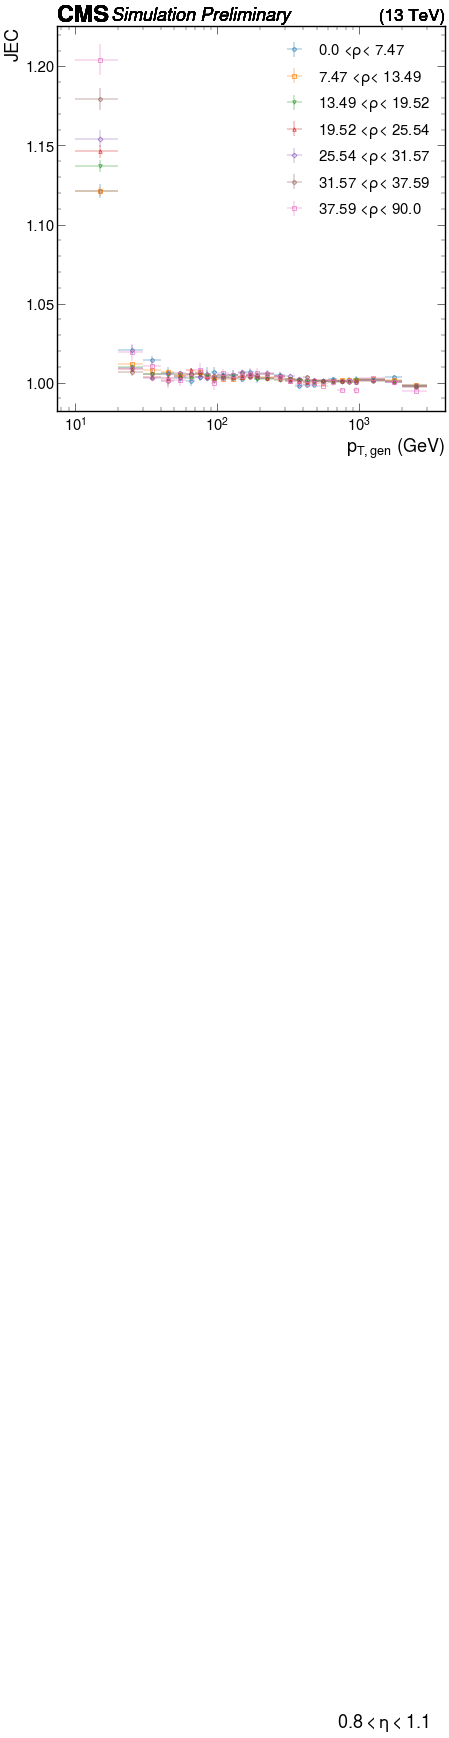

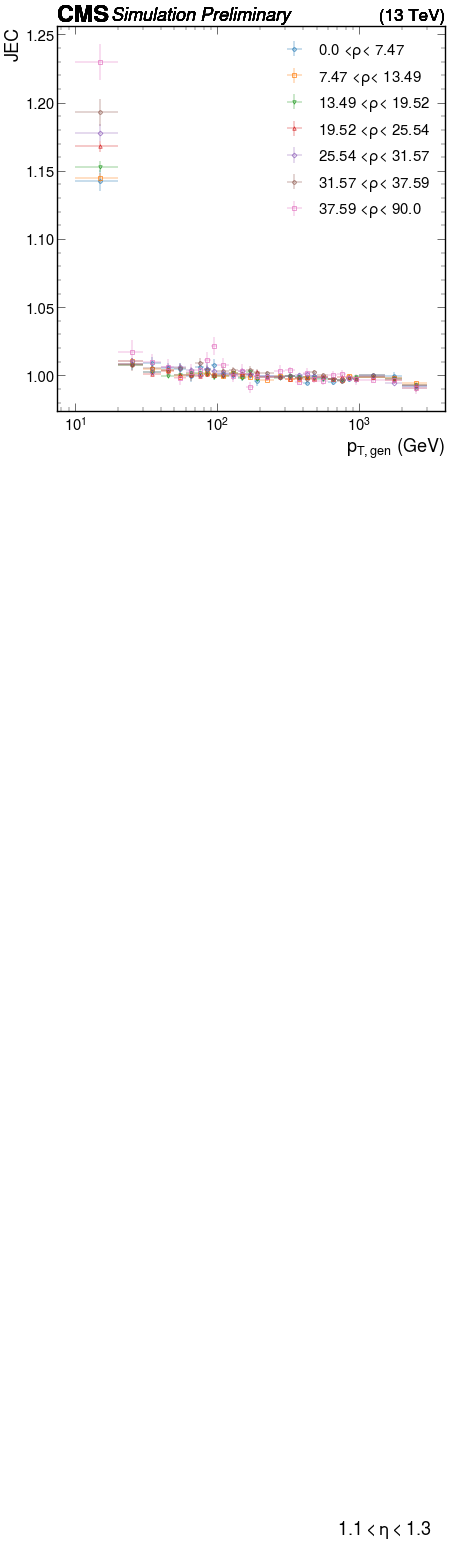

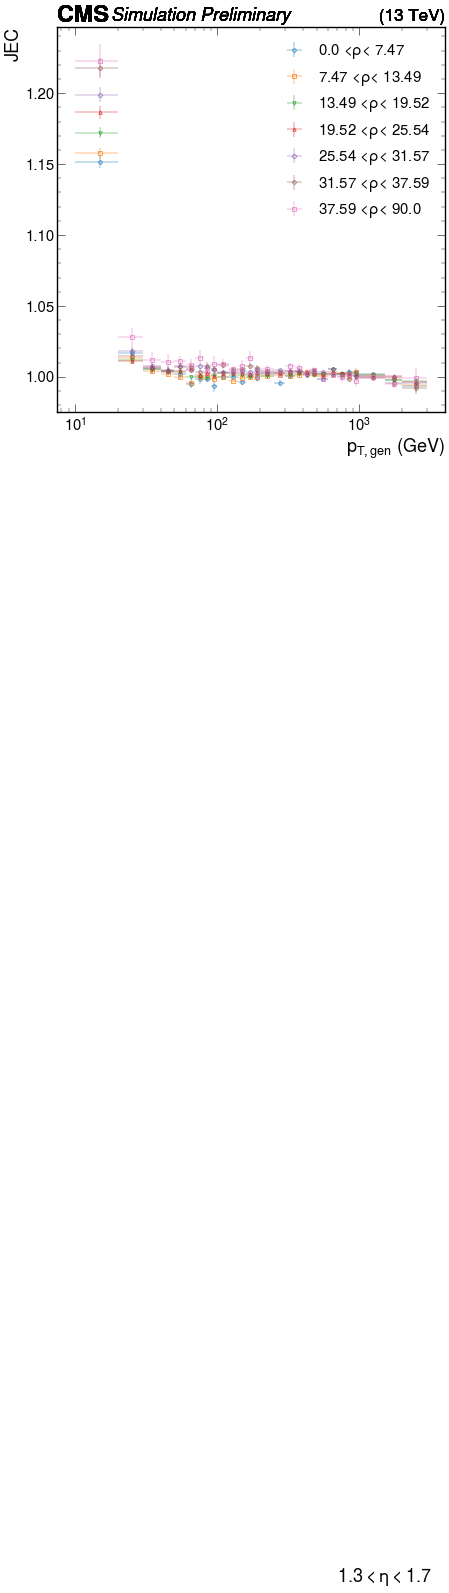

In [56]:
hist = output["pt_reco_over_gen"]

hist_eta_rho_pt_frac = hist.project("eta","rho","pt","frac").to_numpy()[0]
for i, hist_rho_pt_frac in enumerate(hist_eta_rho_pt_frac):
    if i == 5:
        break
    import itertools
    ax = plt.subplot()
    markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
    for i_rho, hist_pt_frac in enumerate(hist_rho_pt_frac):
        histfit = Histfit(hist_pt_frac, frac_values, pt_values)
        histfit.store_parameters()

        mean_list = histfit.parameters["mean"]
        mean_error_list  = histfit.parameters["meanErr"]

        
        ax.errorbar(pt_values, mean_list, np.power(mean_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(rho_bins[i_rho],2))+r" <$\rho$< "  + str(round(rho_bins[i_rho+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
        plt.xlabel(r"$p_{T,gen}$ (GeV)")
        plt.ylabel("JEC")
        plt.xscale("log")
        
        hep.cms.label("Preliminary")
        plt.legend()
    plt.text(700, 0.15, str(round(eta_bins[i],1))+r'$ <\eta< $'+str(round(eta_bins[i+1],1)))
    plt.show()
        #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')